In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("online_retail.csv")
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data Cleaning & Preprocessing

In [6]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [7]:
data = data.dropna(subset=["CustomerID"])

In [8]:
data = data[(data["Quantity"] > 0) & (data["UnitPrice"] > 0)]

In [9]:
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

In [19]:
print(data.info())
print(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
None
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [20]:
import datetime as dt
max_date = data["InvoiceDate"].max()

In [21]:
rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (max_date - x.max()).days,   # Recency
    "InvoiceNo": "nunique",                              # Frequency
    "TotalPrice": "sum"                                  # Monetary
})

In [22]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

In [23]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


### Assign RFM Scores

In [28]:
rfm["R_Score"] = pd.cut(rfm["Recency"], 5, labels=[5,4,3,2,1])   # معكوس: الأقل أيام ياخد 5
rfm["F_Score"] = pd.cut(rfm["Frequency"], 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.cut(rfm["Monetary"], 5, labels=[1,2,3,4,5])

In [31]:
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].astype(int).sum(axis=1)


In [32]:
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,1,1,2,112,4
12347.0,1,7,4310.00,5,1,1,511,7
12348.0,74,4,1797.24,5,1,1,511,7
12349.0,18,1,1757.55,5,1,1,511,7
12350.0,309,1,334.40,1,1,1,111,3
...,...,...,...,...,...,...,...,...
18280.0,277,1,180.60,2,1,1,211,4
18281.0,180,1,80.82,3,1,1,311,5
18282.0,7,2,178.05,5,1,1,511,7


### Group Customers

In [33]:
def segment_me(row):
    if row["RFM_Score"] >= 12:
        return "Champions"
    elif row["RFM_Score"] >= 9:
        return "Loyal Customers"
    elif row["RFM_Score"] >= 6:
        return "Potential"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(segment_me, axis=1)

print(rfm["Segment"].value_counts())


Segment
Potential          3281
At Risk            1041
Loyal Customers      13
Champions             3
Name: count, dtype: int64


### Visualization

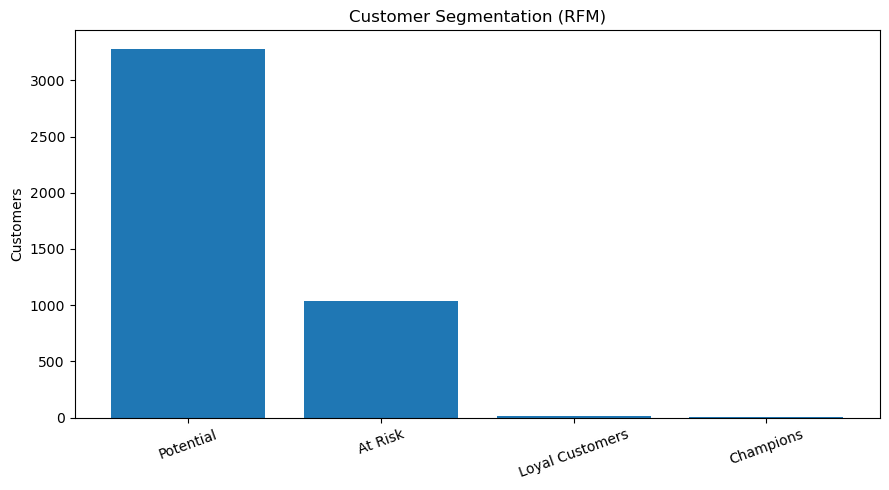

In [37]:
seg_counts = rfm["Segment"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(9,5))
plt.bar(seg_counts.index, seg_counts.values)
plt.title("Customer Segmentation (RFM)")
plt.ylabel("Customers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

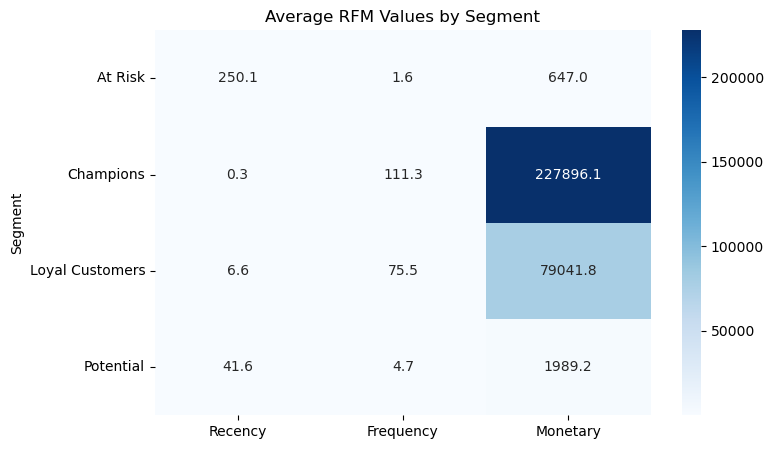

In [44]:
rfm_means = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()

plt.figure(figsize=(8,5))
sns.heatmap(rfm_means, annot=True, cmap="Blues", fmt=".1f")
plt.title('Average RFM Values by Segment')
plt.show()